#0.0 Install BaseMap Lib

In [1]:
!pip install numpy matplotlib folium

Defaulting to user installation because normal site-packages is not writeable

distutils: c:\program files\python39\Include\UNKNOWN
sysconfig: c:\program files\python39\Include
user = False
home = None
root = None
prefix = None
distutils: C:\Users\Rodrigo\AppData\Roaming\Python\Python39\Include\UNKNOWN
sysconfig: C:\Users\Rodrigo\AppData\Roaming\Python\Python39\Include
user = True
home = None
root = None
prefix = None
You should consider upgrading via the 'c:\program files\python39\python.exe -m pip install --upgrade pip' command.


#0.1 Imports

In [2]:
# pacotes usados neste notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import datetime
from PIL import Image
from matplotlib.patches import Polygon
#from mpl_toolkits.basemap import Basemap
import folium
from folium import plugins

#1.0 Frame the problem
Sao Paolo is the most populous state in Brazil and its State Capital, Sao Paolo City is the biggest city in Brazil and the 4th in entire world.
One between several economical market with relevant importancy in Sao Paulo City is its real state rental and sales market. Its numbers are quite impressive, reaching a sum of aproximately 20 billions reais in recent years [1].
Despite the world pandemic situation, real state market in Sao Paolo City kept its numbers ascending.[2]
Getting to know this market details and also extract some information from it that allows to predict house pricing seems to be reasonable and meaningful.


**References:**

[1] SECOVI SP, "Mercado imobiliário mantém resultados positivos em outubro", https://www.secovi.com.br/noticias/mercado-imobiliario-mantem-resultados-positivos-em-outubro/15088, (accessed on 2021-11-01).

[2] Honorio, Gustavo, G1, "https://g1.globo.com/sp/sao-paulo/noticia/2021/09/14/cidade-de-sao-paulo-bate-recorde-historico-de-venda-de-imoveis-em-meio-a-pandemia-especialista-ve-contradicao.ghtml", (accessed on 2021-11-01).

In [3]:
#setting config for plotting
sns.set_theme(style="whitegrid")

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

#1.1 Getting the data

In [4]:
df_raw_data = pd.read_csv('https://github.com/rpbarros/d2apr/blob/main/datasets/properties.csv?raw=true', sep=",")
df_raw_data.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,SwimmingPool,New,District,NegotiationType,PropertyType,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436


#1.1 Data attributes structure and meaning

In [5]:
df_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13640 entries, 0 to 13639
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Price            13640 non-null  int64  
 1   Condo            13640 non-null  int64  
 2   Size             13640 non-null  int64  
 3   Rooms            13640 non-null  int64  
 4   Toilets          13640 non-null  int64  
 5   Suites           13640 non-null  int64  
 6   Parking          13640 non-null  int64  
 7   Elevator         13640 non-null  int64  
 8   Furnished        13640 non-null  int64  
 9   SwimmingPool     13640 non-null  int64  
 10  New              13640 non-null  int64  
 11  District         13640 non-null  object 
 12  NegotiationType  13640 non-null  object 
 13  PropertyType     13640 non-null  object 
 14  Latitude         13640 non-null  float64
 15  Longitude        13640 non-null  float64
dtypes: float64(2), int64(11), object(3)
memory usage: 1.7+ MB


Data structure seems ok, no null values and the data type for each attribute seems fine as well.
The meaning of each data attribute are as follows:

* Price - Final price advertised (R$ Brazilian Real)
* Condo - Condominium expenses (unknown values are marked as zero)
* Size - The property size in Square Meters m² (private areas only)
* Rooms - Number of bedrooms
* Toilets - Number of toilets (all toilets)
* Suites - Number of bedrooms with a private bathroom (en suite)
* Parking - Number of parking spots
* Elevator - Binary value: 1 if there is elevator in the building, 0 otherwise
* Furnished - Binary value: 1 if the property is funished, 0 otherwise
* SwimmingPool - Binary value: 1 if the property has swimming pool, 0 otherwise
* New - Binary value: 1 if the property is very recent, 0 otherwise
* District - The neighborhood and city where the property is located, e.i: Itaim Bibi/São Paulo
* NegotiationType - Sale or Rent
* PropertyType - The property type
* Latitude - Geographic location
* Longitude - Geographic location

# 1.2 Data distribution
Histograms allow data checking regarding its distribution.

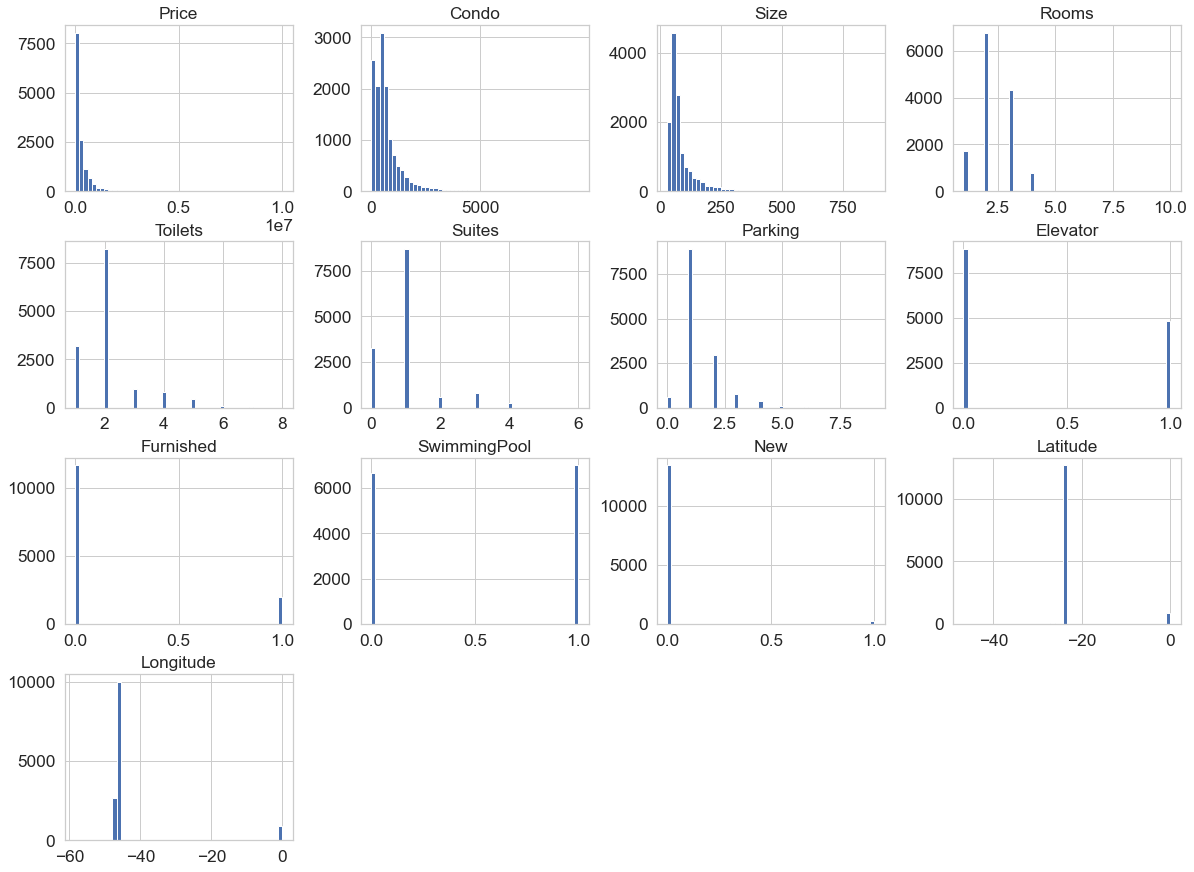

In [6]:
# plot a histogram for each numeric attibute from the dataframe
df_raw_data.hist(bins=50, figsize=(20,15))
display()  # just to avoid texts in the notebook output

Histogram suggestes that a data problem exists related to Latitude / Longitude information. It will be dealt later. 

# 1.4 Check for duplicates

In [7]:
#check for duplicates
df_raw_data.duplicated().any()

True

# 1.4.1 Drop duplicated samples

In [8]:
#drop duplicates
df = df_raw_data.copy()
df = df.drop_duplicates()
df.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,SwimmingPool,New,District,NegotiationType,PropertyType,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436


# 1.5 Exploratory Data Analysis
In order to get to know the dataset, lets dive into it and inspect attribues values, ranges and so on in order to collect some findings about its structure and meaning.

# 1.5.1 Plot a map with geographical data.

In [9]:
coord=[]
for lat,lng in zip(df.Latitude.values,df.Longitude.values):
  coord.append([lat,lng])
coord

[[-23.543138, -46.479486],
 [-23.550239, -46.480718],
 [-23.542818, -46.485665],
 [-23.547171, -46.483014],
 [-23.525025, -46.482436],
 [-23.548751, -46.477195],
 [-23.54984, -46.484137],
 [-23.53974, -46.49267],
 [-23.548751, -46.477195],
 [-23.548751, -46.477195],
 [-23.55185, -46.491169],
 [-23.545761, -46.479509],
 [-23.552073, -46.483411],
 [-23.541366, -46.483726],
 [-23.543955, -46.586619],
 [-23.544698, -46.602114],
 [-23.546104, -46.594579],
 [-23.534606, -46.595084],
 [-23.53962, -46.596337],
 [-23.544698, -46.602114],
 [-23.53838, -46.589441],
 [-23.538163, -46.591505],
 [-23.540023, -46.586898],
 [-23.544698, -46.602114],
 [-23.540212, -46.585702],
 [-23.538134, -46.594059],
 [-23.538163, -46.591505],
 [-23.532871, -46.601244],
 [-23.534606, -46.595084],
 [-23.546089, -46.590325],
 [-23.546104, -46.594579],
 [-23.538794, -46.605664],
 [-23.538767, -46.594706],
 [-23.550987, -46.590908],
 [-23.53838, -46.589441],
 [-23.538134, -46.594059],
 [-23.540085, -46.593312],
 [-23.53

In [10]:
map = folium.Map(location=[-23.55,-46.63], zoom_start=3)
map.add_child(folium.LatLngPopup())
map.add_child(plugins.HeatMap(coord, radius=25, blur=15))        
map

As histrograms suggests, a geografical plot of this data evidences that some data cleaning is needed based on Latitude and Longitude attributes. Some data rows results on misplaced points.

# 1.5.2 Plot the data (scatterplot)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

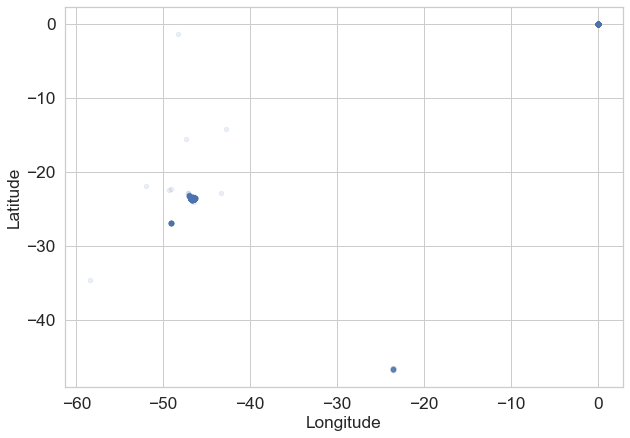

In [11]:
df.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.1, figsize=(10, 7))

# 1.5.3 Sao Paolo city coordinates
Sao Paolo city limits are known and the coordinates of its extreme points are aproximately:

* SP East Longitude: -46.8247
* SP West Longitude: -46.3664
* SP North Latitude -23.3573
* SP South Latitude -24.0078


Based on the known coordinates above, data points must fullfill some caracteristics:
Longitude is always bigger than Latitude and they are limited as above.


In [12]:
df[df['Latitude'] < df['Longitude']]

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,SwimmingPool,New,District,NegotiationType,PropertyType,Latitude,Longitude
1113,1300,637,50,2,2,1,1,1,0,0,0,Jabaquara/São Paulo,rent,apartment,-46.648904,-23.652027
1211,2200,500,30,1,2,1,1,1,0,1,0,Moema/São Paulo,rent,apartment,-46.655399,-23.607013
1583,2600,974,76,2,2,1,2,1,1,1,0,Alto de Pinheiros/São Paulo,rent,apartment,-46.715115,-23.540783
1792,1400,580,60,3,2,1,1,1,0,1,0,Jaguaré/São Paulo,rent,apartment,-46.749039,-23.545329
1937,4200,800,97,2,3,1,2,1,1,1,0,Perdizes/São Paulo,rent,apartment,-46.678478,-23.534683
1962,4000,360,35,1,2,1,1,1,1,1,0,Pinheiros/São Paulo,rent,apartment,-46.700223,-23.568745
5545,380000,528,48,2,2,1,2,1,0,0,0,Consolação/São Paulo,sale,apartment,-46.648555,-23.548484
6888,490000,1000,89,2,2,1,1,0,0,0,0,Cambuci/São Paulo,sale,apartment,-46.626667,-23.577821
9773,1100,200,45,2,2,1,1,0,1,0,0,Vila Curuçá/São Paulo,rent,apartment,-46.428927,-23.517640
9811,1700,290,55,2,2,1,1,1,0,1,0,Vila Prudente/São Paulo,rent,apartment,-46.577355,-23.598180


# 1.5.4 Fix exchanged data
It seems some data has Latitude and Longitude exchanged. Lets fix that.

In [13]:
s = df['Latitude'] < df['Longitude']
df.loc[s, ['Latitude','Longitude']] = df.loc[s, ['Longitude','Latitude']].values

In [14]:
df.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,SwimmingPool,New,District,NegotiationType,PropertyType,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436


# 1.5.5 Check data distribution (scatterplot)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

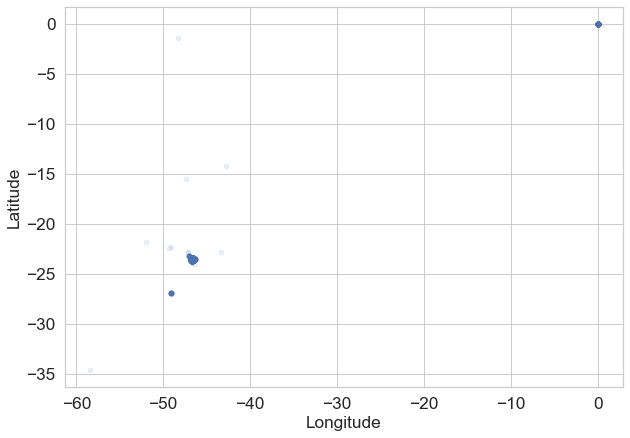

In [15]:
df.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.1, figsize=(10, 7))

It seems some data rows are out of the known limits of Sao Paolo city, lets clean them out

In [16]:
df = df[((df['Latitude'] > -24.0078) & (df['Latitude'] < -23.3573)) & ((df['Longitude'] > -46.8247) & (df['Longitude'] < -46.3664))]

# 1.5.6 Re-check data distribution (scatterplot):

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

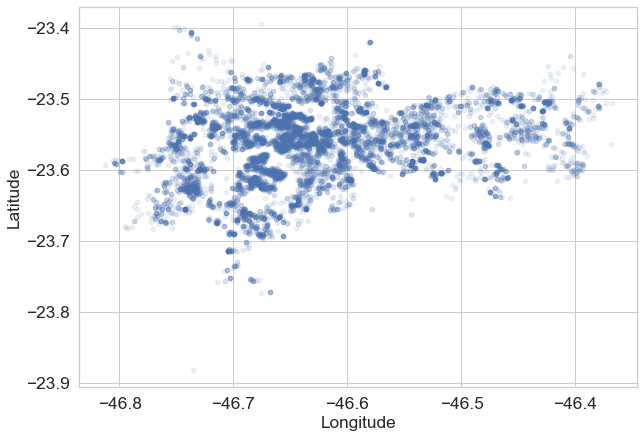

In [17]:
df.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.1, figsize=(10, 7))

It seems that data distribution corresponds to a geografical location that resembles to Sao Paolo City.

# 1.5.7 Plot geographical data into Sao Paolo City limits

In [18]:
coord=[]
for lat,lng in zip(df.Latitude.values,df.Longitude.values):
  coord.append([lat,lng])

map = folium.Map(location=[-23.55,-46.63], zoom_start=11)
map.add_child(folium.LatLngPopup())
map.add_child(plugins.HeatMap(coord, radius=10))        
map

There are still some data that seems to lie outside Sao Paulo city limits but lets keep these data.

# 1.6 Data preparation
It is important to review all dataset attributes. 

# 1.6.1 Extract City from District attribute
It is noticiable that district names includes city name as well. Lets extract city name into a separated attribute.

In [19]:
df[['District', 'City']] = df['District'].str.split('/', expand=True)
df.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,SwimmingPool,New,District,NegotiationType,PropertyType,Latitude,Longitude,City
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.543138,-46.479486,São Paulo
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.550239,-46.480718,São Paulo
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.542818,-46.485665,São Paulo
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.547171,-46.483014,São Paulo
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim,rent,apartment,-23.525025,-46.482436,São Paulo


# 1.6.2 Inspect attributes

In [20]:
df['City'].unique()

array(['São Paulo'], dtype=object)

There´s only one value for City attribute, this attribute is irrelevant and can be removed.

In [21]:
df['District'].unique()

array(['Artur Alvim', 'Belém', 'Cangaíba', 'Carrão', 'Cidade Líder',
       'Cidade Tiradentes', 'Ermelino Matarazzo', 'Iguatemi',
       'Itaim Paulista', 'Itaquera', 'Jardim Helena', 'José Bonifácio',
       'Lajeado', 'Parque do Carmo', 'Penha', 'Ponte Rasa', 'Sapopemba',
       'São Lucas', 'São Mateus', 'São Miguel', 'São Rafael', 'Tatuapé',
       'Vila Curuçá', 'Vila Formosa', 'Vila Jacuí', 'Vila Matilde',
       'Vila Prudente', 'Cambuci', 'Campo Belo', 'Campo Grande',
       'Campo Limpo', 'Capão Redondo', 'Cidade Ademar', 'Cidade Dutra',
       'Cursino', 'Grajaú', 'Ipiranga', 'Itaim Bibi', 'Jabaquara',
       'Jardim Ângela', 'Jardim Paulista', 'Moema', 'Morumbi', 'Pedreira',
       'Sacomã', 'Santo Amaro', 'Saúde', 'Socorro', 'Vila Andrade',
       'Vila Mariana', 'Vila Sônia', 'Alto de Pinheiros', 'Anhanguera',
       'Brasilândia', 'Butantã', 'Cachoeirinha', 'Freguesia do Ó',
       'Jaguaré', 'Jaraguá', 'Lapa', 'Limão', 'Perdizes', 'Pinheiros',
       'Pirituba', 'Raposo

In [22]:
df['PropertyType'].unique()

array(['apartment'], dtype=object)

There´s only one property type on this dataset so this attribute can be removed.

In [23]:
df['SwimmingPool'].unique()

array([0, 1], dtype=int64)

In [24]:
df['Furnished'].unique()

array([0, 1], dtype=int64)

In [25]:
df['Elevator'].unique()

array([0, 1], dtype=int64)

In [26]:
df['Parking'].unique()

array([1, 2, 3, 4, 5, 6, 8, 9, 0, 7], dtype=int64)

In [27]:
df['New'].unique()

array([0, 1], dtype=int64)

In [28]:
df['Suites'].unique()

array([1, 3, 2, 4, 0, 5, 6], dtype=int64)

In [29]:
df['Toilets'].unique()

array([2, 3, 4, 1, 5, 6, 7, 8], dtype=int64)

# 1.6.4 Negotiation types

There are two main subsets inside this dataset: real state for Sale and Rent. Those data sets can separated.

In [30]:
df['NegotiationType'].unique()

array(['rent', 'sale'], dtype=object)

In [31]:
df_sale = df[(df[['NegotiationType']] == 'sale').any(axis=1)]
df_sale.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,SwimmingPool,New,District,NegotiationType,PropertyType,Latitude,Longitude,City
4901,732600,1000,74,1,2,1,2,1,0,1,0,Vila Madalena,sale,apartment,-23.552129,-46.692244,São Paulo
4902,1990000,2400,164,4,5,2,3,1,1,1,0,Vila Madalena,sale,apartment,-23.551613,-46.699106,São Paulo
4903,720000,700,70,2,2,1,1,1,0,1,1,Vila Madalena,sale,apartment,-23.547687,-46.692594,São Paulo
4904,1680000,1580,155,3,5,3,2,1,0,1,0,Vila Madalena,sale,apartment,-23.552590,-46.691104,São Paulo
4905,1200000,900,56,2,2,1,2,0,1,1,0,Vila Madalena,sale,apartment,-23.553087,-46.697890,São Paulo


In [32]:
df_rent = df[(df[['NegotiationType']] == 'rent').any(axis=1)]
df_rent.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,SwimmingPool,New,District,NegotiationType,PropertyType,Latitude,Longitude,City
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.543138,-46.479486,São Paulo
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.550239,-46.480718,São Paulo
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.542818,-46.485665,São Paulo
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.547171,-46.483014,São Paulo
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim,rent,apartment,-23.525025,-46.482436,São Paulo


Base on the above data handling, there are some attibutes that are not needed as representing a single value: 'City', 'Property Type' and 'Negotiation Type'. Those attributes can be droped from each data frame.

In [33]:
df_rent = df_rent.drop(['City'], axis=1)
df_sale = df_sale.drop(['City'], axis=1)

In [34]:
df_rent = df_rent.drop(['PropertyType'], axis=1)
df_sale = df_sale.drop(['PropertyType'], axis=1)

In [35]:
df_sale = df_sale.drop(['NegotiationType'], axis=1)
df_rent = df_rent.drop(['NegotiationType'], axis=1)

In [36]:
df_rent.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,SwimmingPool,New,District,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim,-23.525025,-46.482436


In [37]:
df_sale.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,SwimmingPool,New,District,Latitude,Longitude
4901,732600,1000,74,1,2,1,2,1,0,1,0,Vila Madalena,-23.552129,-46.692244
4902,1990000,2400,164,4,5,2,3,1,1,1,0,Vila Madalena,-23.551613,-46.699106
4903,720000,700,70,2,2,1,1,1,0,1,1,Vila Madalena,-23.547687,-46.692594
4904,1680000,1580,155,3,5,3,2,1,0,1,0,Vila Madalena,-23.552590,-46.691104
4905,1200000,900,56,2,2,1,2,0,1,1,0,Vila Madalena,-23.553087,-46.697890


# 2.0 Looking for correlations

<ipython-input-38-feac2aafb67d>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df_rent.corr(), dtype=np.bool))  # creates a triangular matrix based on the pandas correlation matrix


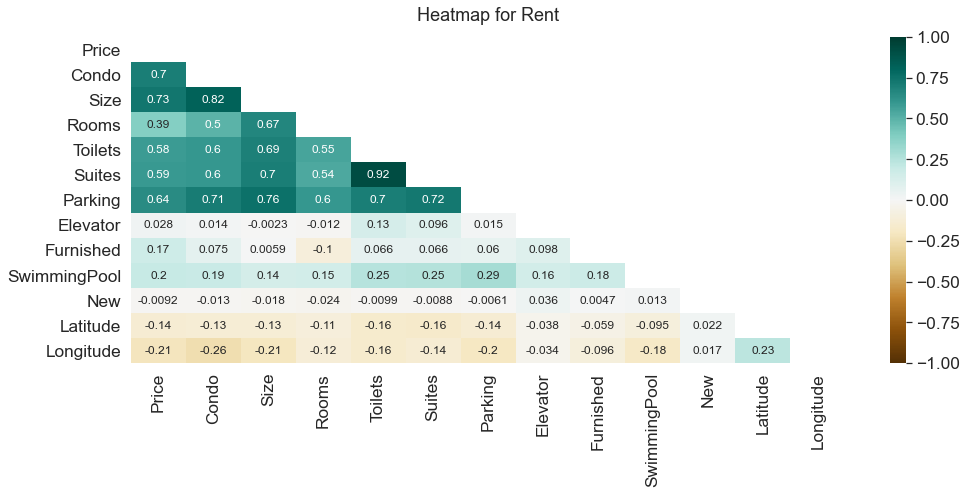

In [38]:
# plotting the correlation coeficients as a heatmap
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df_rent.corr(), dtype=np.bool))  # creates a triangular matrix based on the pandas correlation matrix

heatmap = sns.heatmap(df_rent.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Heatmap for Rent', fontdict={'fontsize':18}, pad=16);

<ipython-input-39-c86da3ceb48d>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df_sale.corr(), dtype=np.bool))  # creates a triangular matrix based on the pandas correlation matrix


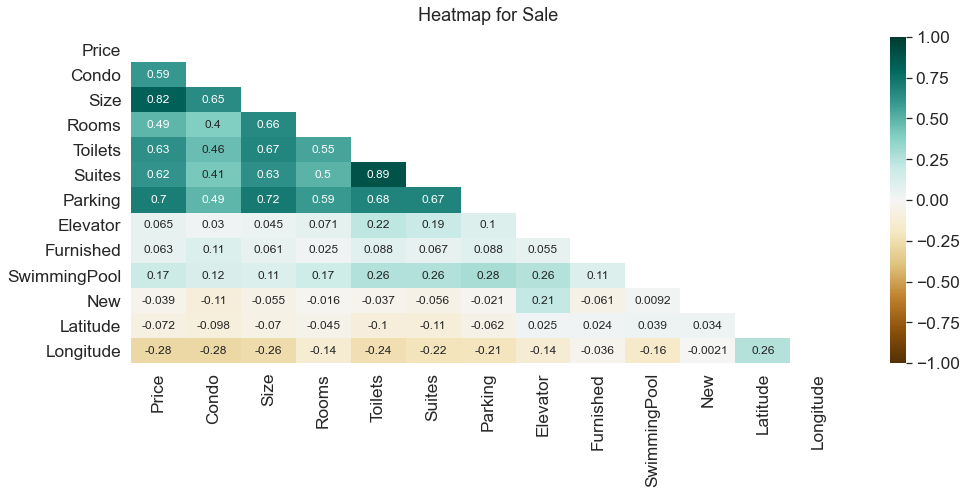

In [39]:
# plotting the correlation coeficients as a heatmap
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df_sale.corr(), dtype=np.bool))  # creates a triangular matrix based on the pandas correlation matrix

heatmap = sns.heatmap(df_sale.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Heatmap for Sale', fontdict={'fontsize':18}, pad=16);

In [40]:
numeric_attributes_rent = df_rent.columns.drop('District')
numeric_attributes_sale = df_sale.columns.drop('District')

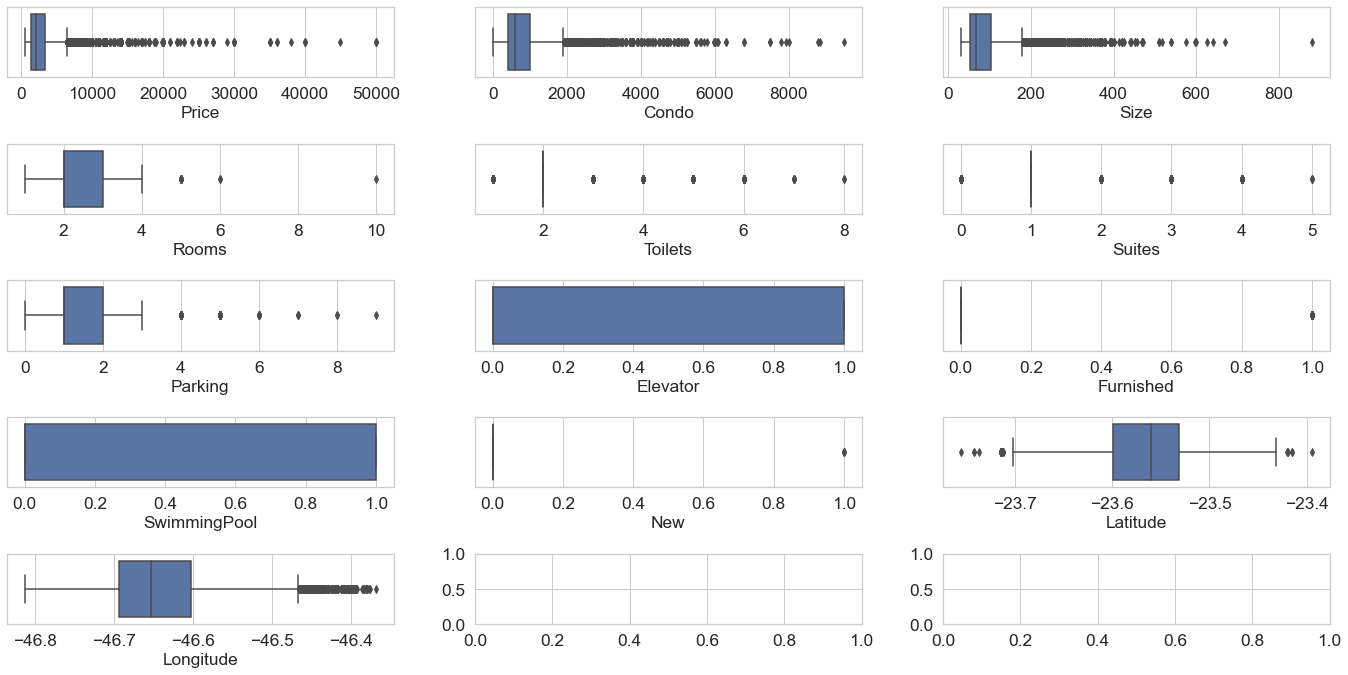

In [41]:
fig, axes = plt.subplots(5, 3, figsize=(20, 10))
fig.tight_layout(pad=3.0)

for i, attr in enumerate(numeric_attributes_rent):
    row = i // 3
    col = i % 3
    sns.boxplot(data=df_rent, x=attr, ax=axes[row, col])

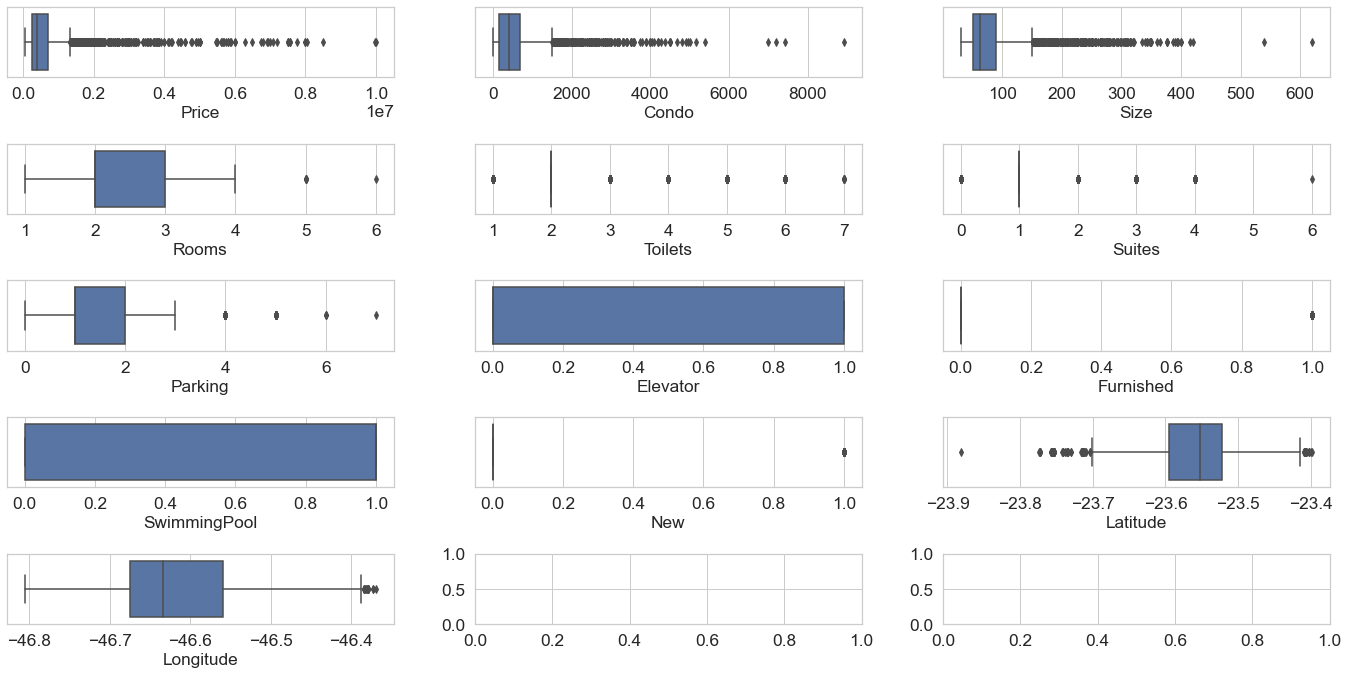

In [42]:
fig, axes = plt.subplots(5, 3, figsize=(20, 10))
fig.tight_layout(pad=3.0)

for i, attr in enumerate(numeric_attributes_sale):
    row = i // 3
    col = i % 3
    sns.boxplot(data=df_sale, x=attr, ax=axes[row, col])

There seems to be several outliners based on Price attribute perspective. However, by checking Parking, Toilets, Suites and Rooms, it is also knew that those features increases the real estate value for rent and sale so lets keep this data for now.

# 3.0 Train and Test data

Some data cleaning were performed previously this step on ML pipeline. Despite this fact, the operations performed where only to remove / fix obvious mistakes on data set and no tampering with values were done. Therefore, previous data cleaning operations should not interfere with the results and no relevant data snooping bias may be present.

In [43]:
from sklearn.model_selection import train_test_split

df_rent_train, df_rent_test = train_test_split(df_rent, test_size=0.2, random_state=42)
df_sale_train, df_sale_test = train_test_split(df_sale, test_size=0.2, random_state=42)
# if you want to keep the reference for the row indices from the original dataset, remove the index=False

df_rent_train.to_csv('./datasets/sp_rent_test.csv', index=False)
df_rent_test.to_csv('./datasets/sp_rent_test.csv', index=False)

df_sale_train.to_csv('./datasets/sp_sale_test.csv', index=False)
df_sale_test.to_csv('./datasets/sp_sale_test.csv', index=False)

# 3.1 Prepare the data

In [44]:
#rent dataset
df_rent_train_pre = df_rent_train.drop(columns=['Price'])
df_rent_train_target = df_rent_train['Price'].copy()

#sale dataset
df_sale_train_pre = df_sale_train.drop(columns=['Price'])
df_sale_train_target = df_sale_train['Price'].copy()

# 3.2 Categorical attribute encoding

## 3.2.1 Separate the numerical and categorical features

In [45]:
# numerical atributes rent
num_attributes_rent = df_rent_train.columns.drop('District')
# numerical atributes sale
num_attributes_sale = df_sale_train.columns.drop('District')

In [46]:
# categorical attributes
cat_attributes = ['District']

In [47]:
# separating the features rent
df_rent_train_num = df_rent_train[num_attributes_rent]
df_rent_train_cat = df_rent_train[cat_attributes]

# separating the features sale
df_sale_train_num = df_sale_train[num_attributes_sale]
df_sale_train_cat = df_sale_train[cat_attributes]

In [48]:
df_rent_train_pre['District'].value_counts()

Mooca              142
Moema              124
Vila Mariana       121
Morumbi            118
Vila Leopoldina    114
                  ... 
Ponte Rasa           5
Guaianazes           5
Sé                   5
Parque do Carmo      3
Grajaú               2
Name: District, Length: 93, dtype: int64

In [49]:
df_sale_train_pre['District'].value_counts()

Casa Verde    119
Bom Retiro    114
Moema         102
Brooklin       97
Brás           92
             ... 
Vila Sônia     21
Iguatemi       17
Jaraguá        15
Perus          15
Medeiros        8
Name: District, Length: 96, dtype: int64

## 3.2.2 Applying One Hot Encoding by Pandas.

In [50]:
# one hot encoding by pandas
df_rent_train_pre = pd.get_dummies(data=df_rent_train_pre, columns=['District'])
df_sale_train_pre = pd.get_dummies(data=df_sale_train_pre, columns=['District'])

## 3.2.3 Saving the pre-processed training set

In [51]:
df_rent_train_pre_saving = df_rent_train_pre.copy()
df_rent_train_pre_saving['Price'] = df_rent_train_target
df_rent_train_pre_saving.head()

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,SwimmingPool,New,...,District_Vila Leopoldina,District_Vila Madalena,District_Vila Maria,District_Vila Mariana,District_Vila Matilde,District_Vila Olimpia,District_Vila Prudente,District_Vila Sônia,District_Água Rasa,Price
10844,1800,150,3,3,2,3,0,0,1,0,...,0,0,0,0,0,0,0,0,0,6000
10959,3200,230,4,3,2,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5000
5340,480,100,2,2,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2500
2546,495,36,1,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2750
9103,1511,118,3,2,1,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4000


In [52]:
df_sale_train_pre_saving = df_sale_train_pre.copy()
df_sale_train_pre_saving['Price'] = df_sale_train_target
df_sale_train_pre_saving.head()

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,SwimmingPool,New,...,District_Vila Leopoldina,District_Vila Madalena,District_Vila Maria,District_Vila Mariana,District_Vila Matilde,District_Vila Olimpia,District_Vila Prudente,District_Vila Sônia,District_Água Rasa,Price
12999,280,50,2,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,220000
6895,1980,148,3,4,3,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1500000
6917,1400,154,3,5,3,3,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1850000
8488,450,128,2,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,450000
12068,200,41,2,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,219900


## 3.2.3 Prepare & Run LinearRegression model.

In [53]:
X_rent_train = df_rent_train_pre.values
y_rent_train = df_rent_train_target.values

X_sale_train = df_sale_train_pre.values
y_sale_train = df_sale_train_target.values

In [54]:
from sklearn.linear_model import LinearRegression

lin_reg_rent = LinearRegression()  # default hyperparameters
lin_reg_sale = LinearRegression()  # default hyperparameters

# training
lin_reg_rent.fit(X_rent_train, y_rent_train)
lin_reg_sale.fit(X_sale_train, y_sale_train)

LinearRegression()

In [55]:
y_rent_train_pred = lin_reg_rent.predict(X_rent_train)
y_sale_train_pred = lin_reg_sale.predict(X_sale_train)

In [56]:
r2_score = lin_reg_rent.score(X_rent_train, y_rent_train)
print(f'R2 for rent= {r2_score}')

R2 for rent= 0.6891968761164249


In [57]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_rent_train, y_rent_train_pred, squared=False)
print(f'RMSE for rent = {rmse}')

RMSE for rent = 2020.8044990659878


In [58]:
r2_score = lin_reg_sale.score(X_sale_train, y_sale_train)
print(f'R2 for sale= {r2_score}')

R2 for sale= 0.8163677110705723


In [59]:
rmse = mean_squared_error(y_sale_train, y_sale_train_pred, squared=False)
print(f'RMSE for sale = {rmse}')

RMSE for sale = 333550.2698669499


Text(0.5, 1.0, 'Price value for rent - Prediction vs Real')

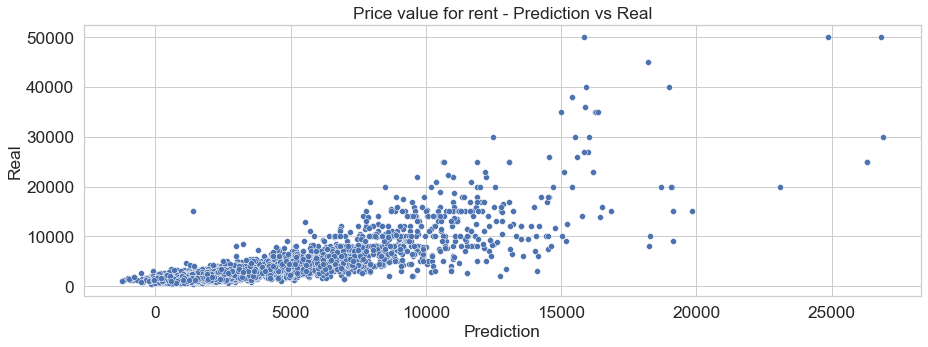

In [60]:
sns.scatterplot(x=y_rent_train_pred, y=y_rent_train)
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Price value for rent - Prediction vs Real')

Text(0.5, 1.0, 'Price value for sale - Prediction vs Real')

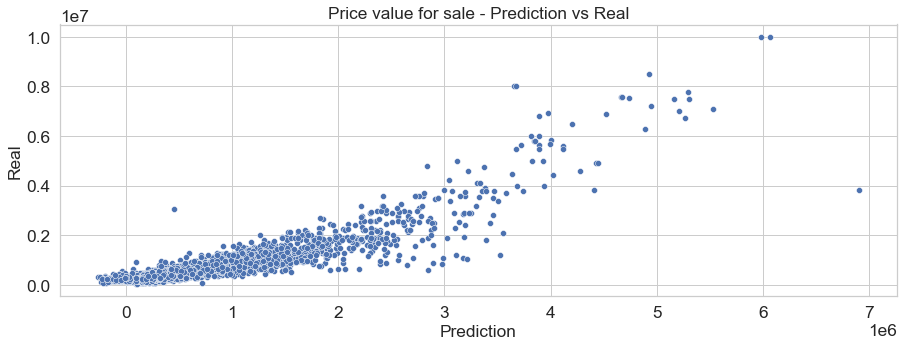

In [61]:
sns.scatterplot(x=y_sale_train_pred, y=y_sale_train)
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Price value for sale - Prediction vs Real')

In [62]:
residual_rent = y_rent_train - y_rent_train_pred
residual_sale = y_sale_train - y_sale_train_pred

Text(0.5, 1.0, 'Rent value - Prediction vs Residual')

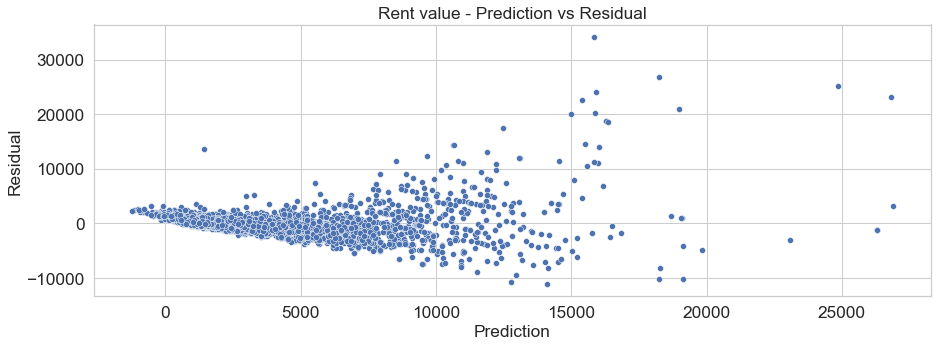

In [63]:
sns.scatterplot(x=y_rent_train_pred, y=residual_rent)
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.title('Rent value - Prediction vs Residual')

Text(0.5, 1.0, 'Sale value - Prediction vs Residual')

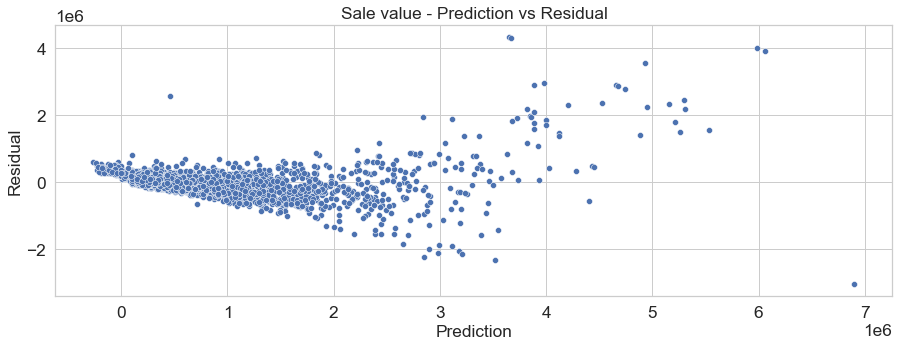

In [64]:
sns.scatterplot(x=y_sale_train_pred, y=residual_sale)
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.title('Sale value - Prediction vs Residual')

Both predictions do not meet the homoscedasticity. Another look on attributes sets may be needed. Even though, **R2 for Sales prediction seems pretty good, 0.947 which is a very good score**.

<AxesSubplot:ylabel='Count'>

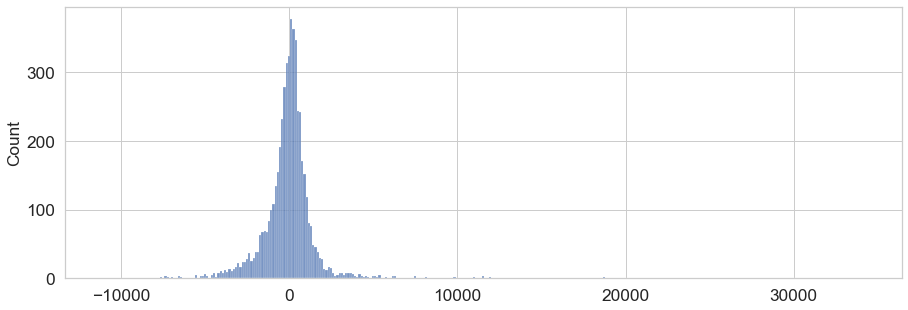

In [65]:
sns.histplot(residual_rent)

<AxesSubplot:ylabel='Count'>

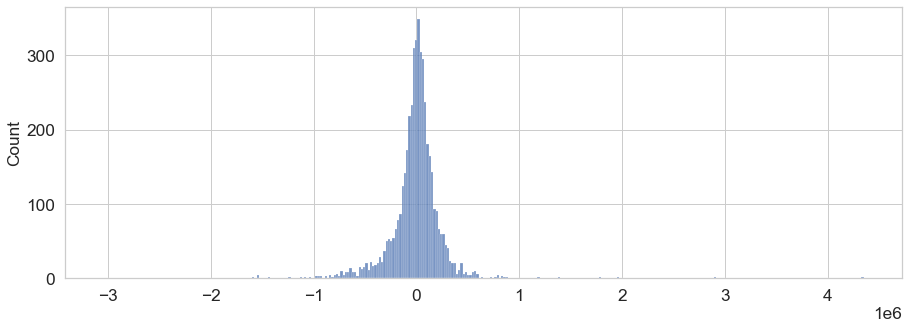

In [66]:
sns.histplot(residual_sale)

# 3.3 Conclusion for first model
The prediction model for **Rent Market** seems better than model for **Sale Market**. It is a fact, though, that both models underfit the training set and by visual inspection of prediction vs residual, it is clear that they also lacks **homoscedasticity**.
Residual for both seems to follow a normal distribution. Lets try to apply some additional techniques on data sets ahead.

# 4 Data preparation review
As the first approach does not seems to result in a good model, lets try some techniques to enhance our model. One of the approach is to remove some ouliers. Another approach is to extract new attributes based on known information. By this point forward, in order to avoid dupplication of the effort and make the analysis simplier, lets also focus our attention on a single market, the **Rent Market**. This decision is also based on the fact that the worst model based on previous result was the model for Rent Market.

## 4.1 Load the data

As the pre-processed train data set is saved, lets get it back.

In [67]:
df_rent_train_pre = df_rent_train_pre_saving;
df_rent_train_pre.head()

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,SwimmingPool,New,...,District_Vila Leopoldina,District_Vila Madalena,District_Vila Maria,District_Vila Mariana,District_Vila Matilde,District_Vila Olimpia,District_Vila Prudente,District_Vila Sônia,District_Água Rasa,Price
10844,1800,150,3,3,2,3,0,0,1,0,...,0,0,0,0,0,0,0,0,0,6000
10959,3200,230,4,3,2,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5000
5340,480,100,2,2,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2500
2546,495,36,1,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2750
9103,1511,118,3,2,1,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4000


## 4.1.1 Outliers
Lets remove the values that are greater than 1.5 times quantile distance + mean.

In [68]:
iqr_rent = round((1.5 * (df_rent_train_pre['Price'].quantile(.75) - df_rent_train_pre['Price'].quantile(.25))) + df_rent_train_pre['Price'].mean(),2)
df_rent_train_pre = df_rent_train_pre[df_rent_train_pre['Price'] < iqr_rent]

In [69]:
iqr_rent

6123.11

## 4.1.2 Add new attributes
Two possibilities of derived attributes that might result on good descriptive attributes are a ratio between toilets/rooms and also the size/rooms.

In [70]:
df_rent_train_pre['ToiletsPerRoom'] = df_rent_train_pre['Toilets'] / df_rent_train_pre['Rooms']
df_rent_train_pre['SizePerRoom'] = df_rent_train_pre['Size'] / df_rent_train_pre['Rooms']
df_rent_train_pre.head()

<ipython-input-70-eb74056d34de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rent_train_pre['ToiletsPerRoom'] = df_rent_train_pre['Toilets'] / df_rent_train_pre['Rooms']
<ipython-input-70-eb74056d34de>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rent_train_pre['SizePerRoom'] = df_rent_train_pre['Size'] / df_rent_train_pre['Rooms']


,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,SwimmingPool,New,...,District_Vila Maria,District_Vila Mariana,District_Vila Matilde,District_Vila Olimpia,District_Vila Prudente,District_Vila Sônia,District_Água Rasa,Price,ToiletsPerRoom,SizePerRoom
10844,1800,150,3,3,2,3,0,0,1,0,...,0,0,0,0,0,0,0,6000,1.000000,50.000000
10959,3200,230,4,3,2,3,0,0,0,0,...,0,0,0,0,0,0,0,5000,0.750000,57.500000
5340,480,100,2,2,0,1,1,0,0,0,...,0,0,0,0,0,0,0,2500,1.000000,50.000000
2546,495,36,1,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,2750,1.000000,36.000000
9103,1511,118,3,2,1,3,1,0,0,0,...,0,0,0,0,0,0,0,4000,0.666667,39.333333


## 4.1.3 Check correlations

In order to check cor correlations, we need to remove the categorical columns added before from the comparision.

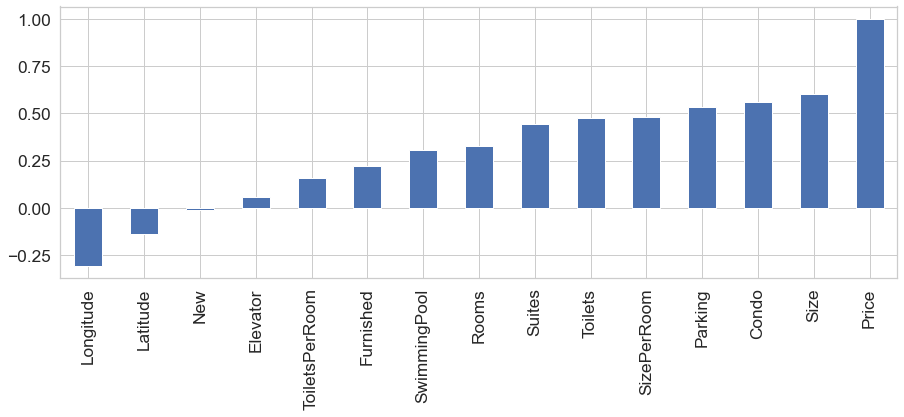

In [71]:
df_rent_train_pre.loc[:, ~df_rent_train_pre.columns.str.startswith('District')].corr()['Price'].sort_values().plot.bar();

It seems that attributes New and Elevator have little influence on Price that is the focus of this study. Those variables can be propped when dealing with real states for rent.

In [72]:
df_rent_train_pre = df_rent_train_pre.drop(['New', 'Elevator'], axis=1)
df_rent_train_pre.head()

,Condo,Size,Rooms,Toilets,Suites,Parking,Furnished,SwimmingPool,Latitude,Longitude,...,District_Vila Maria,District_Vila Mariana,District_Vila Matilde,District_Vila Olimpia,District_Vila Prudente,District_Vila Sônia,District_Água Rasa,Price,ToiletsPerRoom,SizePerRoom
10844,1800,150,3,3,2,3,0,1,-23.551586,-46.698023,...,0,0,0,0,0,0,0,6000,1.000000,50.000000
10959,3200,230,4,3,2,3,0,0,-23.560253,-46.699183,...,0,0,0,0,0,0,0,5000,0.750000,57.500000
5340,480,100,2,2,0,1,0,0,-23.568037,-46.593205,...,0,0,0,0,0,0,0,2500,1.000000,50.000000
2546,495,36,1,1,0,1,0,1,-23.537947,-46.652422,...,0,0,0,0,0,0,0,2750,1.000000,36.000000
9103,1511,118,3,2,1,3,0,0,-23.562526,-46.647866,...,0,0,0,0,0,0,0,4000,0.666667,39.333333


# 5 Train ML algorithm

Lets separate the independent attributes from dependent attribute that is the focus of the prediction:

In [73]:
#rent dataset
df_rent_train_target = df_rent_train_pre['Price'].copy()
df_rent_train_pre = df_rent_train_pre.drop(columns=['Price'])

In [74]:
X_train = df_rent_train_pre.values
y_train = df_rent_train_target.values

## 5.1 Training the models

In [75]:
linear_regressor = LinearRegression()  # default parameters
linear_regressor.fit(X_train, y_train)

LinearRegression()

## 5.2 Evaluation of the prediction model

In [76]:
y_train_pred = linear_regressor.predict(X_train)

In [77]:
r2_score = linear_regressor.score(X_train, y_train)
print(f'R² = {r2_score}')

R² = 0.7324076243297721


In [78]:
rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print(f'RMSE = {rmse}')

RMSE = 632.1218478298542


The R2 score seems better than previous calculation. The second model including the derived attributes and the removal of some irrelevant attributes resulted in a score of 0.732 against the previous score of 0.689, which is an expressive increase.
The mean squared error dropped from 2020 to 632 which is also a relevant enhancement.

Text(0.5, 1.0, 'Rent value - Prediction vs Real')

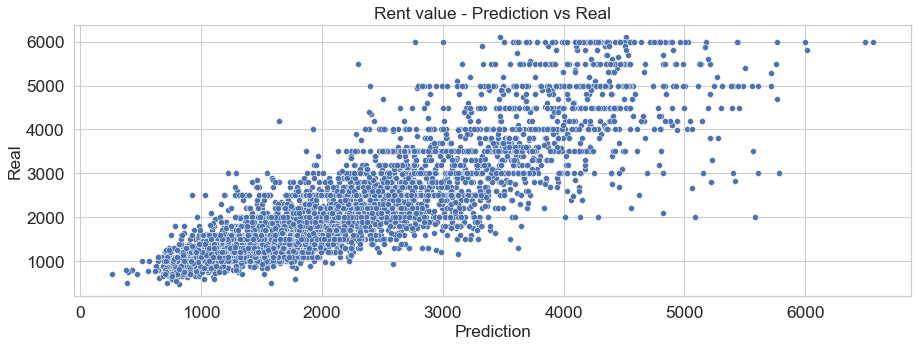

In [79]:
sns.scatterplot(x=y_train_pred, y=y_train)
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Rent value - Prediction vs Real')

In [80]:
residual = y_train - y_train_pred

Text(0.5, 1.0, 'Rent value - Prediction vs Residual')

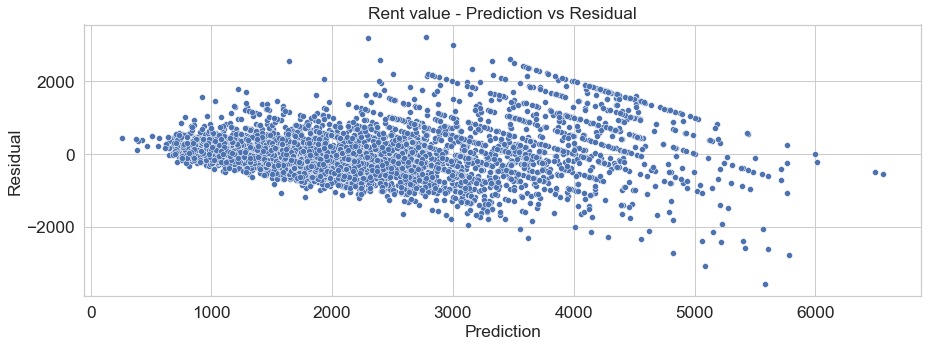

In [81]:
sns.scatterplot(x=y_train_pred, y=residual)
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.title('Rent value - Prediction vs Residual')

<AxesSubplot:ylabel='Count'>

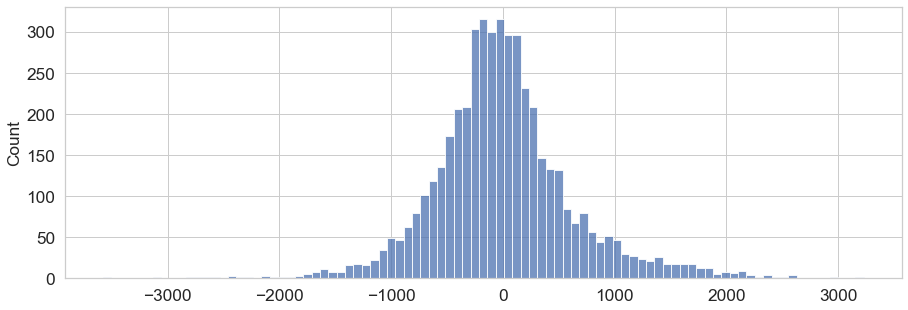

In [82]:
sns.histplot(residual)

## 5.3 Conclusion for second model
Although the expressive enhancement on the prediction model, it still underfit the training set. By visual inspection of prediction vs residual, it is clear that is also lacks **homoscedasticity**. The residual still seems to follow a normal distribution histogram.

Lets apply some other techniques on **Rent Market** data set to try to enhance the prediction model ahead.

# 6 Atributes Scalling
In order to apply attribute scalling, it is needed to keep appart dummy variables from numeric variables.

In [83]:
numeric_variables = df_rent_train_pre.loc[:, ~df_rent_train_pre.columns.str.startswith('District')].columns;
dummy_variables  = df_rent_train_pre.loc[:, df_rent_train_pre.columns.str.startswith('District')].columns;

X_train_numeric = df_rent_train_pre[numeric_variables].values
X_train_dummy = df_rent_train_pre[dummy_variables].values

In [84]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

# learn the median and IQR for each feature from our training (numeric) set
scaler.fit(X_train_numeric)

RobustScaler()

In [85]:
print(f'center: {scaler.center_}\n')

center: [561.5         65.           2.           2.           1.
   1.           0.           0.         -23.557146   -46.64481105
   1.          32.        ]



In [86]:
# aplying feature scaling
X_train_numeric_norm = scaler.transform(X_train_numeric)

In [87]:
# our final normalized training set
X_train = np.hstack((X_train_numeric_norm, X_train_dummy))

In [88]:

X_train

array([[ 2.63510638,  2.23684211,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 5.61382979,  4.34210526,  2.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.17340426,  0.92105263,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.68404255, -0.60526316,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08191489, -0.13157895,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.34361702, -0.71052632,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## 6.1 Train Algorithm

In [89]:
# we already have X_train
y_train = df_rent_train_target.values
y_train

array([6000, 5000, 2500, ...,  660, 1250, 1100], dtype=int64)

### 6.1.1 Linear Regression

In [90]:
from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()  # default parameters
linear_regressor.fit(X_train, y_train)

LinearRegression()

### 6.1.2 Decision Tree Regression

In [91]:
from sklearn.tree import DecisionTreeRegressor

tree_regressor = DecisionTreeRegressor()  # default hyperparameters
tree_regressor.fit(X_train, y_train)

DecisionTreeRegressor()

## 6.2 Evaluating the training data set

### 6.2.1 Linear Regression

In [92]:
#prediction
y_train_pred_lin = linear_regressor.predict(X_train)


In [93]:
#evaluation
r2_score = linear_regressor.score(X_train, y_train)
print(f'R² linear regression = {r2_score}')

R² linear regression = 0.7324075303101362


In [94]:
from sklearn.metrics import mean_squared_error

lin_reg_rmse = mean_squared_error(y_train, y_train_pred_lin, squared=False)
print(f'RMSE = {lin_reg_rmse}')

RMSE = 632.1219588790959


#### 6.2.1.1 Visual Analysis

Text(0.5, 1.0, 'Price - Prediction vs Real - Linear Regression')

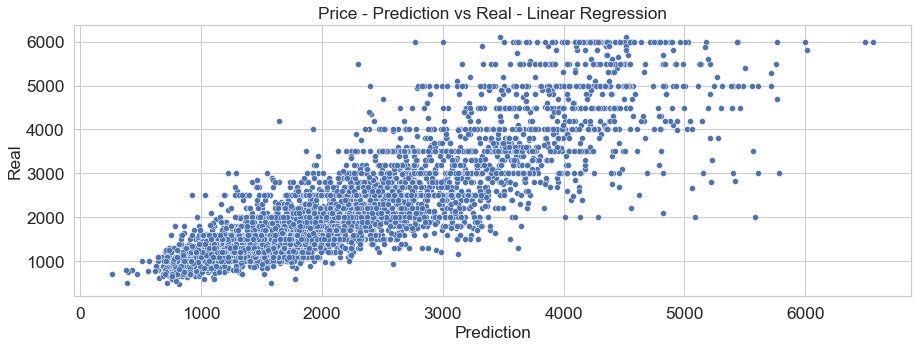

In [95]:
sns.scatterplot(x=y_train_pred_lin, y=y_train)
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Price - Prediction vs Real - Linear Regression')

Text(0.5, 1.0, 'Price - Prediction vs Residual - Linear Regression')

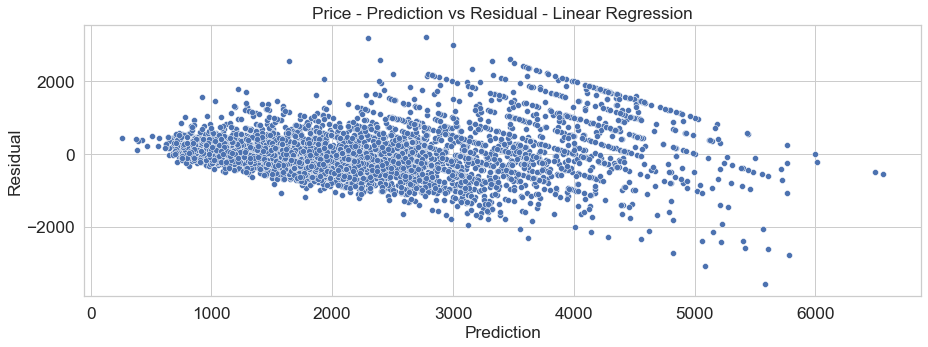

In [96]:
residual = y_train - y_train_pred_lin

sns.scatterplot(x=y_train_pred_lin, y=residual)
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.title('Price - Prediction vs Residual - Linear Regression')

#### 6.2.1.2 Evaluation
Based on these results, the Attribute scalling technique did not result in an enhancement on Linear Regression model. It is slighly worse, with R2 of 0.7324075 against 0.7324076, a difference on 7th decimal only. The same happens for RMS that increased to 632.1219 against 632.1218 previously.

### 6.2.2 Decision Tree Regression

In [97]:
#prediction
y_train_pred_tree_reg = tree_regressor.predict(X_train)

In [98]:
#evaluation
from sklearn.metrics import r2_score

tree_reg_r2 = r2_score(y_train, y_train_pred_tree_reg)
print(f'R² decision tree regression = {tree_reg_r2}')

R² decision tree regression = 0.9996403835676837


In [99]:
from sklearn.metrics import mean_squared_error

tree_reg_rmse = mean_squared_error(y_train, y_train_pred_tree_reg, squared=False)
print(f'RMSE = {tree_reg_rmse}')

RMSE = 23.173076612272244


#### 6.2.2.1 Visual Analysis

Text(0.5, 1.0, 'Price - Prediction vs Real - Decision Tree Regression')

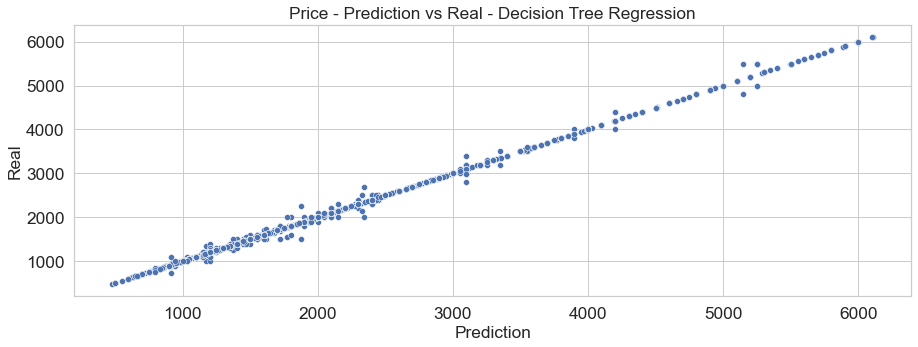

In [100]:
sns.scatterplot(x=y_train_pred_tree_reg, y=y_train)
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Price - Prediction vs Real - Decision Tree Regression')

Text(0.5, 1.0, 'Price - Prediction vs Residual |')

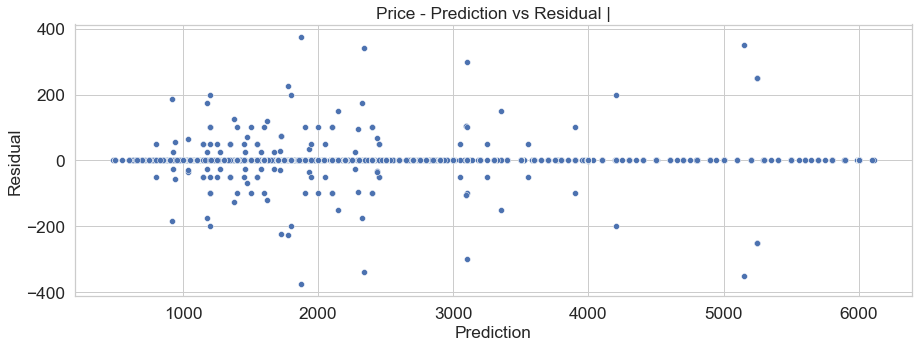

In [101]:
residual = y_train - y_train_pred_tree_reg

sns.scatterplot(x=y_train_pred_tree_reg, y=residual)
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.title('Price - Prediction vs Residual |')

#### 6.2.2.2 Evaluation
It seems that Decision Tree Regression overfits the trainning dataset. A cross validation is needed.

## 6.3 Cross Validation

In [102]:
# printing function
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

### 6.3.1 Linear Regression

In [103]:
from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()
lin_neg_mse_scores = cross_val_score(lin_reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

lin_rmse_scores = np.sqrt(-lin_neg_mse_scores)

In [104]:
display_scores(lin_rmse_scores)

Scores: [709.1973034  670.32554513 627.60004325 577.21301469 622.95455319
 616.41879007 637.67821488 612.87695863 698.80780835 674.79806002]
Mean: 644.787029159551
Standard deviation: 39.78900292320227


### 6.3.2 Decision Tree Regression

In [105]:

from sklearn.model_selection import cross_val_score

tree_reg = DecisionTreeRegressor(random_state=42)
tree_neg_mse_scores = cross_val_score(tree_reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

tree_rmse_scores = np.sqrt(-tree_neg_mse_scores)

In [106]:
display_scores(tree_rmse_scores)

Scores: [817.64414392 768.6454207  753.92234048 724.47378439 762.45154472
 825.46009206 833.76970319 820.33402922 825.21772683 787.67264855]
Mean: 791.9591434068296
Standard deviation: 35.881885931452096


### 6.3.3 Cross Validation conclusions

It seems that the **Decision Tree Regression** looks worse than **Linear Regression** in this data set. By using the splitting into 10 folds, it was possible to get the understanding that Decision Tree Regression has a mean RMSE of 791 against the RMSE for Linear Regression of 644.

# 7 Automate data processing

## 7.1 Reload original dataset

In [107]:
df_rent_numeric = df_rent_train.loc[:, ~df_rent_train.columns.str.startswith('District')];
df_rent_dummy  = df_rent_train.loc[:, df_rent_train.columns.str.startswith('District')];

In [108]:
df_rent_numeric.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,SwimmingPool,New,Latitude,Longitude
10844,6000,1800,150,3,3,2,3,0,0,1,0,-23.551586,-46.698023
10959,5000,3200,230,4,3,2,3,0,0,0,0,-23.560253,-46.699183
5340,2500,480,100,2,2,0,1,1,0,0,0,-23.568037,-46.593205
2546,2750,495,36,1,1,0,1,0,0,1,0,-23.537947,-46.652422
9103,4000,1511,118,3,2,1,3,1,0,0,0,-23.562526,-46.647866


In [109]:
df_rent_dummy.head()

,District
10844,Alto de Pinheiros
10959,Pinheiros
5340,Mooca
2546,Santa Cecília
9103,Bela Vista


In [110]:
# store the target outcome into a numpy array
y_train = df_rent_numeric['Price'].values
y_train

array([6000, 5000, 2500, ...,  660, 1250, 1100], dtype=int64)

In [111]:
# overwrite the dataframe with only the features  
df_rent_numeric = df_rent_numeric.drop(columns=['Price'])
df_rent_numeric.head()

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,SwimmingPool,New,Latitude,Longitude
10844,1800,150,3,3,2,3,0,0,1,0,-23.551586,-46.698023
10959,3200,230,4,3,2,3,0,0,0,0,-23.560253,-46.699183
5340,480,100,2,2,0,1,1,0,0,0,-23.568037,-46.593205
2546,495,36,1,1,0,1,0,0,1,0,-23.537947,-46.652422
9103,1511,118,3,2,1,3,1,0,0,0,-23.562526,-46.647866


## 7.2 Transformer

In [112]:
# template to create an own estimation
from sklearn.base import BaseEstimator, TransformerMixin


class NameOfYourTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        return None  # return the transformed data instead of None

In [113]:
# get the integer index of each attribute/column:
for index, column_name in enumerate(df_rent_numeric.columns):
    print(f'{index} = {column_name}')

0 = Condo
1 = Size
2 = Rooms
3 = Toilets
4 = Suites
5 = Parking
6 = Elevator
7 = Furnished
8 = SwimmingPool
9 = New
10 = Latitude
11 = Longitude


In [114]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

size_col_idx = 1
rooms_col_idx = 2
toilets_col_idx = 3

class HousingFeatEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        n_rows = X.shape[0]
        
        # creating the new features
        toilets_per_room = X[:, toilets_col_idx] / X[:, rooms_col_idx]
        size_per_room = X[:, size_col_idx] / X[:, rooms_col_idx]
        
        # to concatenate the new arrays as columns in our feature matrix, we need to reshape first
        toilets_per_room = toilets_per_room.reshape((n_rows, 1))
        size_per_room = size_per_room.reshape((n_rows, 1))
        
        # concatenating the new features into the feature matrix X
        X_out = np.hstack((X, toilets_per_room, size_per_room))
        
        return X_out

In [115]:
feat_engineer = HousingFeatEngineering()

housing_train_num_new_feats = feat_engineer.transform(df_rent_numeric.values)  # we need to convert it to numpy first
housing_train_num_new_feats

array([[ 1.80000000e+03,  1.50000000e+02,  3.00000000e+00, ...,
        -4.66980226e+01,  1.00000000e+00,  5.00000000e+01],
       [ 3.20000000e+03,  2.30000000e+02,  4.00000000e+00, ...,
        -4.66991826e+01,  7.50000000e-01,  5.75000000e+01],
       [ 4.80000000e+02,  1.00000000e+02,  2.00000000e+00, ...,
        -4.65932049e+01,  1.00000000e+00,  5.00000000e+01],
       ...,
       [ 2.40000000e+02,  4.20000000e+01,  2.00000000e+00, ...,
        -4.63800440e+01,  1.00000000e+00,  2.10000000e+01],
       [ 6.00000000e+02,  6.00000000e+01,  2.00000000e+00, ...,
        -4.66849030e+01,  1.00000000e+00,  3.00000000e+01],
       [ 4.00000000e+02,  3.80000000e+01,  2.00000000e+00, ...,
        -4.67597600e+01,  1.00000000e+00,  1.90000000e+01]])

In [116]:
housing_train_num_new_feats.shape

(5218, 14)

In [117]:
# show the new feats
housing_train_num_new_feats[:, -3:]

array([[-46.6980226,   1.       ,  50.       ],
       [-46.6991826,   0.75     ,  57.5      ],
       [-46.5932049,   1.       ,  50.       ],
       ...,
       [-46.380044 ,   1.       ,  21.       ],
       [-46.684903 ,   1.       ,  30.       ],
       [-46.75976  ,   1.       ,  19.       ]])

## 7.3 Attribute scalling

In [118]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaler.fit(df_rent_numeric)

RobustScaler()

In [119]:
df_rent_numeric_scaled = scaler.transform(df_rent_numeric)
df_rent_numeric_scaled

array([[ 2.00000000e+00,  1.64000000e+00,  1.00000000e+00, ...,
         0.00000000e+00,  1.25108792e-01, -4.99625052e-01],
       [ 4.33333333e+00,  3.24000000e+00,  2.00000000e+00, ...,
         0.00000000e+00, -4.99301775e-04, -5.12393938e-01],
       [-2.00000000e-01,  6.40000000e-01,  0.00000000e+00, ...,
         0.00000000e+00, -1.13312516e-01,  6.54172605e-01],
       ...,
       [-6.00000000e-01, -5.20000000e-01,  0.00000000e+00, ...,
         0.00000000e+00,  7.34233767e-01,  3.00057543e+00],
       [ 0.00000000e+00, -1.60000000e-01,  0.00000000e+00, ...,
         0.00000000e+00, -1.65984940e+00, -3.55208949e-01],
       [-3.33333333e-01, -6.00000000e-01,  0.00000000e+00, ...,
         0.00000000e+00, -1.63958746e+00, -1.17920939e+00]])

## 7.4 Categorical attribute encoding

In [120]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore')
df_rent_dummy_1hot = encoder.fit_transform(df_rent_dummy)
df_rent_dummy_1hot

<5218x93 sparse matrix of type '<class 'numpy.float64'>'
	with 5218 stored elements in Compressed Sparse Row format>

In [121]:
df_rent_dummy_1hot.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [122]:
encoder.categories_

[array(['Alto de Pinheiros', 'Anhanguera', 'Aricanduva', 'Artur Alvim',
        'Barra Funda', 'Bela Vista', 'Belém', 'Bom Retiro', 'Brasilândia',
        'Brooklin', 'Brás', 'Butantã', 'Cachoeirinha', 'Cambuci',
        'Campo Belo', 'Campo Grande', 'Campo Limpo', 'Cangaíba',
        'Capão Redondo', 'Carrão', 'Casa Verde', 'Cidade Ademar',
        'Cidade Dutra', 'Cidade Líder', 'Cidade Tiradentes', 'Consolação',
        'Cursino', 'Ermelino Matarazzo', 'Freguesia do Ó', 'Grajaú',
        'Guaianazes', 'Iguatemi', 'Ipiranga', 'Itaim Bibi',
        'Itaim Paulista', 'Itaquera', 'Jabaquara', 'Jaguaré', 'Jaraguá',
        'Jardim Helena', 'Jardim Paulista', 'Jardim Ângela', 'Jaçanã',
        'José Bonifácio', 'Lajeado', 'Lapa', 'Liberdade', 'Limão',
        'Mandaqui', 'Medeiros', 'Moema', 'Mooca', 'Morumbi', 'Pari',
        'Parque do Carmo', 'Pedreira', 'Penha', 'Perdizes', 'Pinheiros',
        'Pirituba', 'Ponte Rasa', 'Raposo Tavares', 'República',
        'Rio Pequeno', 'Sacomã', '

## 7.5 Preprocessing pipelines

### 7.5.1 Numerical Data

In [123]:
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('feat_engineering', HousingFeatEngineering()),
    ('robust_scaler', RobustScaler())
])

In [124]:
df_rent_numeric_preprocessed = num_pipeline.fit_transform(df_rent_numeric.values)

In [125]:
df_rent_numeric_preprocessed

array([[ 2.        ,  1.64      ,  1.        , ..., -0.49962505,
         0.        ,  0.89189189],
       [ 4.33333333,  3.24      ,  2.        , ..., -0.51239394,
        -0.75      ,  1.2972973 ],
       [-0.2       ,  0.64      ,  0.        , ...,  0.65417261,
         0.        ,  0.89189189],
       ...,
       [-0.6       , -0.52      ,  0.        , ...,  3.00057543,
         0.        , -0.67567568],
       [ 0.        , -0.16      ,  0.        , ..., -0.35520895,
         0.        , -0.18918919],
       [-0.33333333, -0.6       ,  0.        , ..., -1.17920939,
         0.        , -0.78378378]])

In [126]:
df_rent_numeric.shape

(5218, 12)

In [127]:
df_rent_numeric_preprocessed.shape

(5218, 14)

### 7.5.2 Categorical Data

In [128]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('one-hot-encoding', OneHotEncoder(handle_unknown='ignore'))
])

In [129]:
df_rent_dummy_preprocessed = cat_pipeline.fit_transform(df_rent_dummy)

In [130]:
df_rent_dummy_preprocessed.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [131]:
np.all(df_rent_dummy_preprocessed.toarray() == df_rent_dummy_1hot)

True

### 7.5.3 Column Transform

In [132]:
df_rent_train.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,SwimmingPool,New,District,Latitude,Longitude
10844,6000,1800,150,3,3,2,3,0,0,1,0,Alto de Pinheiros,-23.551586,-46.698023
10959,5000,3200,230,4,3,2,3,0,0,0,0,Pinheiros,-23.560253,-46.699183
5340,2500,480,100,2,2,0,1,1,0,0,0,Mooca,-23.568037,-46.593205
2546,2750,495,36,1,1,0,1,0,0,1,0,Santa Cecília,-23.537947,-46.652422
9103,4000,1511,118,3,2,1,3,1,0,0,0,Bela Vista,-23.562526,-46.647866


In [133]:
# store the target outcome into a numpy array
y_train = df_rent_train['Price'].values
y_train

# overwrite the dataframe with only the features  
df_rent_train = df_rent_train.drop(columns=['Price'])
df_rent_train.head()

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,SwimmingPool,New,District,Latitude,Longitude
10844,1800,150,3,3,2,3,0,0,1,0,Alto de Pinheiros,-23.551586,-46.698023
10959,3200,230,4,3,2,3,0,0,0,0,Pinheiros,-23.560253,-46.699183
5340,480,100,2,2,0,1,1,0,0,0,Mooca,-23.568037,-46.593205
2546,495,36,1,1,0,1,0,0,1,0,Santa Cecília,-23.537947,-46.652422
9103,1511,118,3,2,1,3,1,0,0,0,Bela Vista,-23.562526,-46.647866


In [134]:
# numerical atributes rent
num_attributes = df_rent_train.columns.drop('District')
# categorical attributes
cat_attributes = ['District']

In [135]:
num_attributes

Index(['Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking', 'Elevator',
       'Furnished', 'SwimmingPool', 'New', 'Latitude', 'Longitude'],
      dtype='object')

In [136]:
cat_attributes

['District']

In [137]:
df_rent_train.head()

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,SwimmingPool,New,District,Latitude,Longitude
10844,1800,150,3,3,2,3,0,0,1,0,Alto de Pinheiros,-23.551586,-46.698023
10959,3200,230,4,3,2,3,0,0,0,0,Pinheiros,-23.560253,-46.699183
5340,480,100,2,2,0,1,1,0,0,0,Mooca,-23.568037,-46.593205
2546,495,36,1,1,0,1,0,0,1,0,Santa Cecília,-23.537947,-46.652422
9103,1511,118,3,2,1,3,1,0,0,0,Bela Vista,-23.562526,-46.647866


# NOTE: **If the SimpleImputer is not added to the transformation, algorithm fails** 
This failure is yet to be understood.

In [138]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('feat_engineering', HousingFeatEngineering()),
    ('robust_scaler', RobustScaler())
])

cat_pipeline = Pipeline([
    ('one-hot-encoding', OneHotEncoder(handle_unknown='ignore'))
])


# (name, transformer, columns)
preprocessed_pipeline = ColumnTransformer([
    ('numerical', num_pipeline, num_attributes.values),
    ('categorical', cat_pipeline, cat_attributes)
])

In [139]:
df_rent_pre_npy = preprocessed_pipeline.fit_transform(df_rent_train)

In [140]:
df_rent_pre_npy.toarray()

array([[ 2.        ,  1.64      ,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 4.33333333,  3.24      ,  2.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.2       ,  0.64      ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.6       , -0.52      ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.16      ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.33333333, -0.6       ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [141]:
df_rent_pre_npy.shape

(5218, 107)

In [142]:
preprocessed_pipeline.named_transformers_

{'numerical': Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                 ('feat_engineering', HousingFeatEngineering()),
                 ('robust_scaler', RobustScaler())]),
 'categorical': Pipeline(steps=[('one-hot-encoding', OneHotEncoder(handle_unknown='ignore'))])}

In [143]:
preprocessed_pipeline.transformers_

[('numerical',
  Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                  ('feat_engineering', HousingFeatEngineering()),
                  ('robust_scaler', RobustScaler())]),
  array(['Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking',
         'Elevator', 'Furnished', 'SwimmingPool', 'New', 'Latitude',
         'Longitude'], dtype=object)),
 ('categorical',
  Pipeline(steps=[('one-hot-encoding', OneHotEncoder(handle_unknown='ignore'))]),
  ['District'])]

### 7.5.4 Saving & Load the pipeline

In [144]:
import joblib
# saving the pipeline
joblib.dump(preprocessed_pipeline, './models/preprocessed_pipeline.pkl')

# to load the pipeline
loaded_preprocessed_pipeline = joblib.load('./models/preprocessed_pipeline.pkl')

In [145]:
df_rent_pre_npy_2 = loaded_preprocessed_pipeline.transform(df_rent_train)
df_rent_pre_npy_2.toarray()

array([[ 2.        ,  1.64      ,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 4.33333333,  3.24      ,  2.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.2       ,  0.64      ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.6       , -0.52      ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.16      ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.33333333, -0.6       ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [146]:
np.all(df_rent_pre_npy.toarray() == df_rent_pre_npy_2.toarray())

True

In [147]:
np.save('./datasets/df_rent_train_pre_numpy.npy', df_rent_pre_npy)

## 7.6 Training the ML Algorithm

In [148]:
X_train = df_rent_pre_npy
X_train.shape

(5218, 107)

In [149]:
y_train.shape

(5218,)

### 7.6.1 Training the model

#### 7.6.1.1 Cross validation for Linear Regression

In [150]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()  # default parameters
lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)

In [151]:
# printing function
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [152]:
display_scores(lin_rmse_scores)

Scores: [2179.06119153 2248.38360974 1994.45176875 1955.15693664 2100.32489555
 1804.19584188 1593.3976388  2321.99640824 2084.44752299 2203.60090691]
Mean: 2048.5016721019547
Standard deviation: 209.34925904422744


#### 7.6.1.2 Training final model

In [153]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [154]:
### saving the model
import joblib
joblib.dump(lin_reg, './models/linear_regression.pkl')

['./models/linear_regression.pkl']

# 8. Evaluation on the Test Set

## 8.1 Load the data

In [155]:
### Load the testing set
sp_rent_test = pd.read_csv('./datasets/sp_rent_test.csv')
sp_rent_test

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,SwimmingPool,New,District,Latitude,Longitude
0,1000,680,70,2,2,1,1,0,0,1,0,Cangaíba,-23.507829,-46.532525
1,1200,0,42,2,2,1,1,1,0,1,0,Itaquera,-23.560670,-46.450742
2,2300,660,65,2,1,0,1,0,0,0,0,Moema,-23.605326,-46.660009
3,3000,1100,138,3,3,2,1,0,0,0,0,Consolação,-23.551458,-46.653961
4,1650,598,95,3,2,1,2,0,0,0,0,Mandaqui,-23.465954,-46.636802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,2400,350,53,2,2,1,1,0,0,0,0,Vila Guilherme,-23.518450,-46.601037
1301,2200,450,44,1,2,1,1,1,0,1,0,Santana,-23.505573,-46.623403
1302,2600,580,68,2,2,1,1,0,0,1,0,Ipiranga,-23.574360,-46.605302
1303,1300,611,70,2,2,1,1,0,0,0,0,Mandaqui,-23.472499,-46.630318


In [156]:
### Separate the _features_ and the _target outcome_
y_test = sp_rent_test['Price'].values
y_test

array([1000, 1200, 2300, ..., 2600, 1300, 1600], dtype=int64)

In [157]:
sp_rent_test = sp_rent_test.drop(columns=['Price'])
sp_rent_test

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,SwimmingPool,New,District,Latitude,Longitude
0,680,70,2,2,1,1,0,0,1,0,Cangaíba,-23.507829,-46.532525
1,0,42,2,2,1,1,1,0,1,0,Itaquera,-23.560670,-46.450742
2,660,65,2,1,0,1,0,0,0,0,Moema,-23.605326,-46.660009
3,1100,138,3,3,2,1,0,0,0,0,Consolação,-23.551458,-46.653961
4,598,95,3,2,1,2,0,0,0,0,Mandaqui,-23.465954,-46.636802
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,350,53,2,2,1,1,0,0,0,0,Vila Guilherme,-23.518450,-46.601037
1301,450,44,1,2,1,1,1,0,1,0,Santana,-23.505573,-46.623403
1302,580,68,2,2,1,1,0,0,1,0,Ipiranga,-23.574360,-46.605302
1303,611,70,2,2,1,1,0,0,0,0,Mandaqui,-23.472499,-46.630318


In [158]:
### Preprocess the Test Set
import joblib
preprocessed_pipeline = joblib.load('./models/preprocessed_pipeline.pkl')

# preprocess the test set
X_test = preprocessed_pipeline.transform(sp_rent_test)
X_test.toarray()

array([[ 0.13333333,  0.04      ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.        , -0.52      ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.1       , -0.06      ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.03333333,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01833333,  0.04      ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.24166667, -0.04      ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## 8.2 Prediction

In [159]:
### loading the trained model
lin_reg = joblib.load('./models/linear_regression.pkl')

### evaluation
y_test_pred = lin_reg.predict(X_test)

### 8.2.3 RMSE

In [160]:
### computing the final score
from sklearn.metrics import mean_squared_error

lin_rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f'RMSE Lin. Reg. in the Test Set: {lin_rmse_test}')

RMSE Lin. Reg. in the Test Set: 1923.0531607757891


### 8.2.4 Confidence interval

In [161]:
confidence_level = 0.95
n = len(y_test)  # the number of testing examples/instances

In [162]:
squared_errors = (y_test_pred - y_test) ** 2
squared_errors

array([1065070.28143794,   10661.7252686 , 3668054.37257577, ...,
        149948.60424451,   16659.24499458,   26562.8038115 ])

In [163]:
standard_error = squared_errors.std() / np.sqrt(n)
standard_error

648888.794951346

In [164]:
from scipy.stats import norm

# alpha ==> confidence level
# loc ==> sample mean
# scale ==> standard error

confidence_interval_squared_errors = norm.interval(alpha=confidence_level, loc=squared_errors.mean(), scale=standard_error)
confidence_interval_squared_errors

(2426334.791093519, 4969932.127245988)

In [165]:
# using the sqrt to keep the erros in the same units
np.sqrt(confidence_interval_squared_errors)

array([1557.66966687, 2229.33445836])

# 9 Conclusion

Evaluating the final results for the model regarding **Rent Market**, the results aren´t good. The erros when evaluating the algorithm on the test data set are way bigger than the errors on train data set. This indicates that he model still need refining.